In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

print(f"numpy version      : {np.__version__}")
print(f"tensorflow version : {tf.__version__}")


numpy version      : 1.26.4
tensorflow version : 2.18.0


Étape 1. Perceptron simple

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')


print("Chargement des données Olivetti Faces...")
faces = fetch_olivetti_faces(shuffle=True, random_state=42)
X, y = faces.data, faces.target

print(f"Forme des données : {X.shape}")
print(f"Nombre de classes : {len(np.unique(y))}")
print(f"Taille d'une image : {int(np.sqrt(X.shape[1]))}x{int(np.sqrt(X.shape[1]))} pixels")

Chargement des données Olivetti Faces...
Forme des données : (400, 4096)
Nombre de classes : 40
Taille d'une image : 64x64 pixels


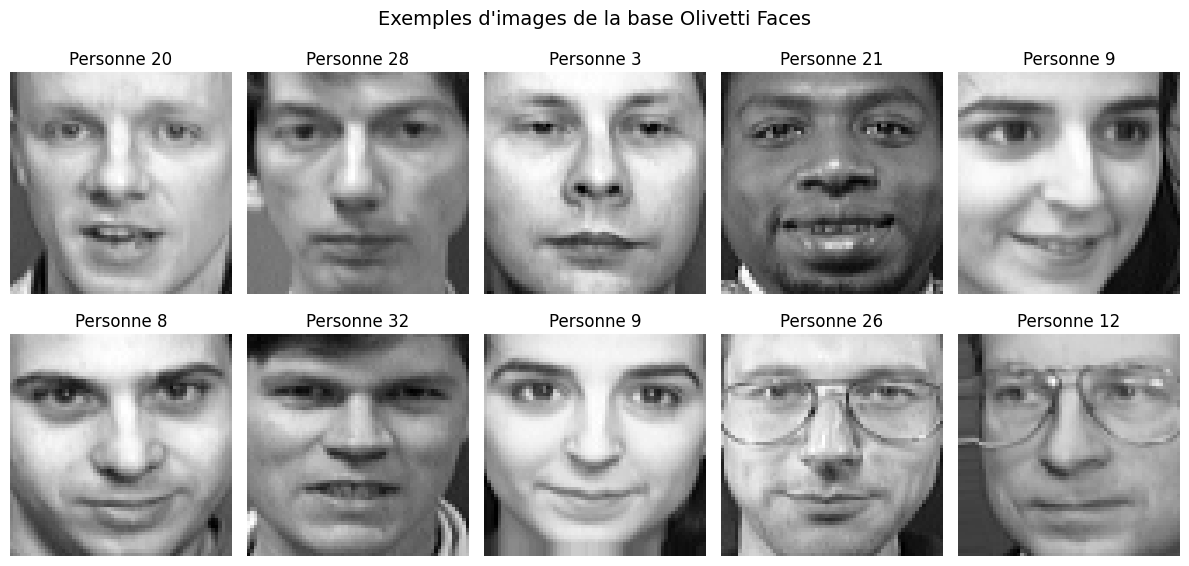

In [3]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle('Exemples d\'images de la base Olivetti Faces', fontsize=14)

for i in range(10):
    ax = axes[i//5, i%5]
    img = X[i].reshape(64, 64)
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Personne {y[i]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f" Taille ensemble d'entraînement : {X_train.shape[0]} échantillons")
print(f" Taille ensemble de test : {X_test.shape[0]} échantillons")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

 Taille ensemble d'entraînement : 280 échantillons
 Taille ensemble de test : 120 échantillons


In [5]:
# PERCEPTRON SIMPLE

class SimplePerceptron:
    """
    Implémentation d'un perceptron simple pour classification multi-classe
    Utilise la stratégie One-vs-All pour la classification multi-classe
    """
    
    def __init__(self, learning_rate=0.01, max_epochs=1000, random_state=42):
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.random_state = random_state
        self.weights = None
        self.bias = None
        self.classes = None
        self.training_history = []
        
    def _sigmoid(self, z):
        """Fonction d'activation sigmoïde"""
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        """
        Entraînement du perceptron
        Args:
            X: données d'entrée (n_samples, n_features)
            y: labels (n_samples,)
        """
        np.random.seed(self.random_state)
        
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        n_classes = len(self.classes)
        
        # poids et biais
        self.weights = np.random.normal(0, 0.01, (n_features, n_classes))
        self.bias = np.zeros(n_classes)
        
        # Conversion des labels
        y_one_hot = np.zeros((n_samples, n_classes))
        for i, cls in enumerate(self.classes):
            y_one_hot[y == cls, i] = 1
        
        print(f"Début de l'entraînement...")
        print(f"   - Taux d'apprentissage : {self.learning_rate}")
        print(f"   - Nombre maximum d'époques : {self.max_epochs}")
        
        for epoch in range(self.max_epochs):
            # Forward pass
            z = np.dot(X, self.weights) + self.bias
            predictions = self._sigmoid(z)
            
            # Calcul de l'erreur
            error = y_one_hot - predictions
            cost = np.mean(np.sum(error**2, axis=1))
            
            # Backward pass
            gradient_w = -np.dot(X.T, error) / n_samples
            gradient_b = -np.mean(error, axis=0)
            
            # Maj
            self.weights -= self.learning_rate * gradient_w
            self.bias -= self.learning_rate * gradient_b
            
            self.training_history.append(cost)
            
            if (epoch + 1) % 100 == 0:
                accuracy = self.score(X, y)
                print(f"   Époque {epoch+1:4d} - Coût: {cost:.6f} - Précision: {accuracy:.4f}")
        
        print("Entraînement terminé!")
        
    def predict(self, X):
        """Prédiction sur de nouvelles données"""
        z = np.dot(X, self.weights) + self.bias
        predictions = self._sigmoid(z)
        predicted_classes = np.argmax(predictions, axis=1)
        return self.classes[predicted_classes]
    
    def score(self, X, y):
        """Calcul de la précision"""
        predictions = self.predict(X)
        return accuracy_score(y, predictions)
    
    def get_weights_images(self):
        return self.weights.T.reshape(len(self.classes), 64, 64)

In [6]:
# ENTRAÎNEMENT DU PERCEPTRON
print("ENTRAÎNEMENT DU PERCEPTRON SIMPLE")
perceptron = SimplePerceptron(
    learning_rate=0.1,
    max_epochs=500,
    random_state=42
)
perceptron.fit(X_train_scaled, y_train)

ENTRAÎNEMENT DU PERCEPTRON SIMPLE
Début de l'entraînement...
   - Taux d'apprentissage : 0.1
   - Nombre maximum d'époques : 500
   Époque  100 - Coût: 14.702448 - Précision: 0.7679
   Époque  200 - Coût: 0.209470 - Précision: 1.0000
   Époque  300 - Coût: 0.003791 - Précision: 1.0000
   Époque  400 - Coût: 0.001485 - Précision: 1.0000
   Époque  500 - Coût: 0.000832 - Précision: 1.0000
Entraînement terminé!


In [7]:
# 4. ÉVALUATION DES PERFORMANCES
print("\n" + "="*60)
print("ÉVALUATION DES PERFORMANCES")
print("="*60)

# Prédictions
y_train_pred = perceptron.predict(X_train_scaled)
y_test_pred = perceptron.predict(X_test_scaled)

# Calcul des précisions
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Précision sur l'ensemble d'entraînement : {train_accuracy:.4f}")
print(f"Précision sur l'ensemble de test : {test_accuracy:.4f}")

print("\n Rapport de classification détaillé :")
print(classification_report(y_test, y_test_pred))


ÉVALUATION DES PERFORMANCES
Précision sur l'ensemble d'entraînement : 1.0000
Précision sur l'ensemble de test : 0.9417

 Rapport de classification détaillé :
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       1.00      1.00      1.00         3
           2       0.67      0.67      0.67         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      0.67      0.80         3
           7       1.00      1.00      1.00         3
           8       0.75      1.00      0.86         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       1.00      0.67      0.80         3
          13       1.00      1.00      1.00         3
          14       0.75      1

Performances du perceptron

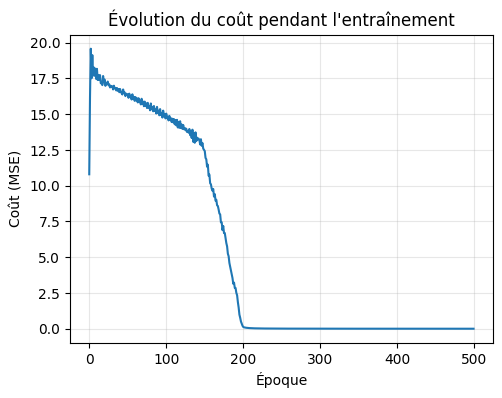

In [8]:
# Courbe d'apprentissage
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(perceptron.training_history)
plt.title('Évolution du coût pendant l\'entraînement')
plt.xlabel('Époque')
plt.ylabel('Coût (MSE)')
plt.grid(True, alpha=0.3)

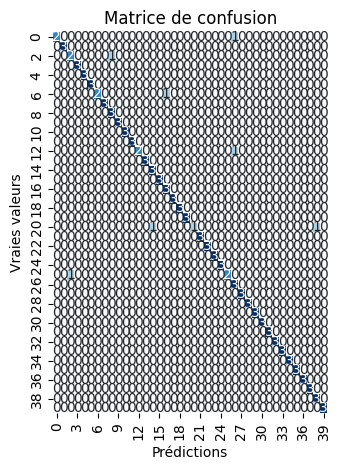

In [9]:
# Matrice de confusion
plt.subplot(1, 2, 2) 
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.tight_layout()
plt.show()


VISUALISATION DES POIDS DU RÉSEAU


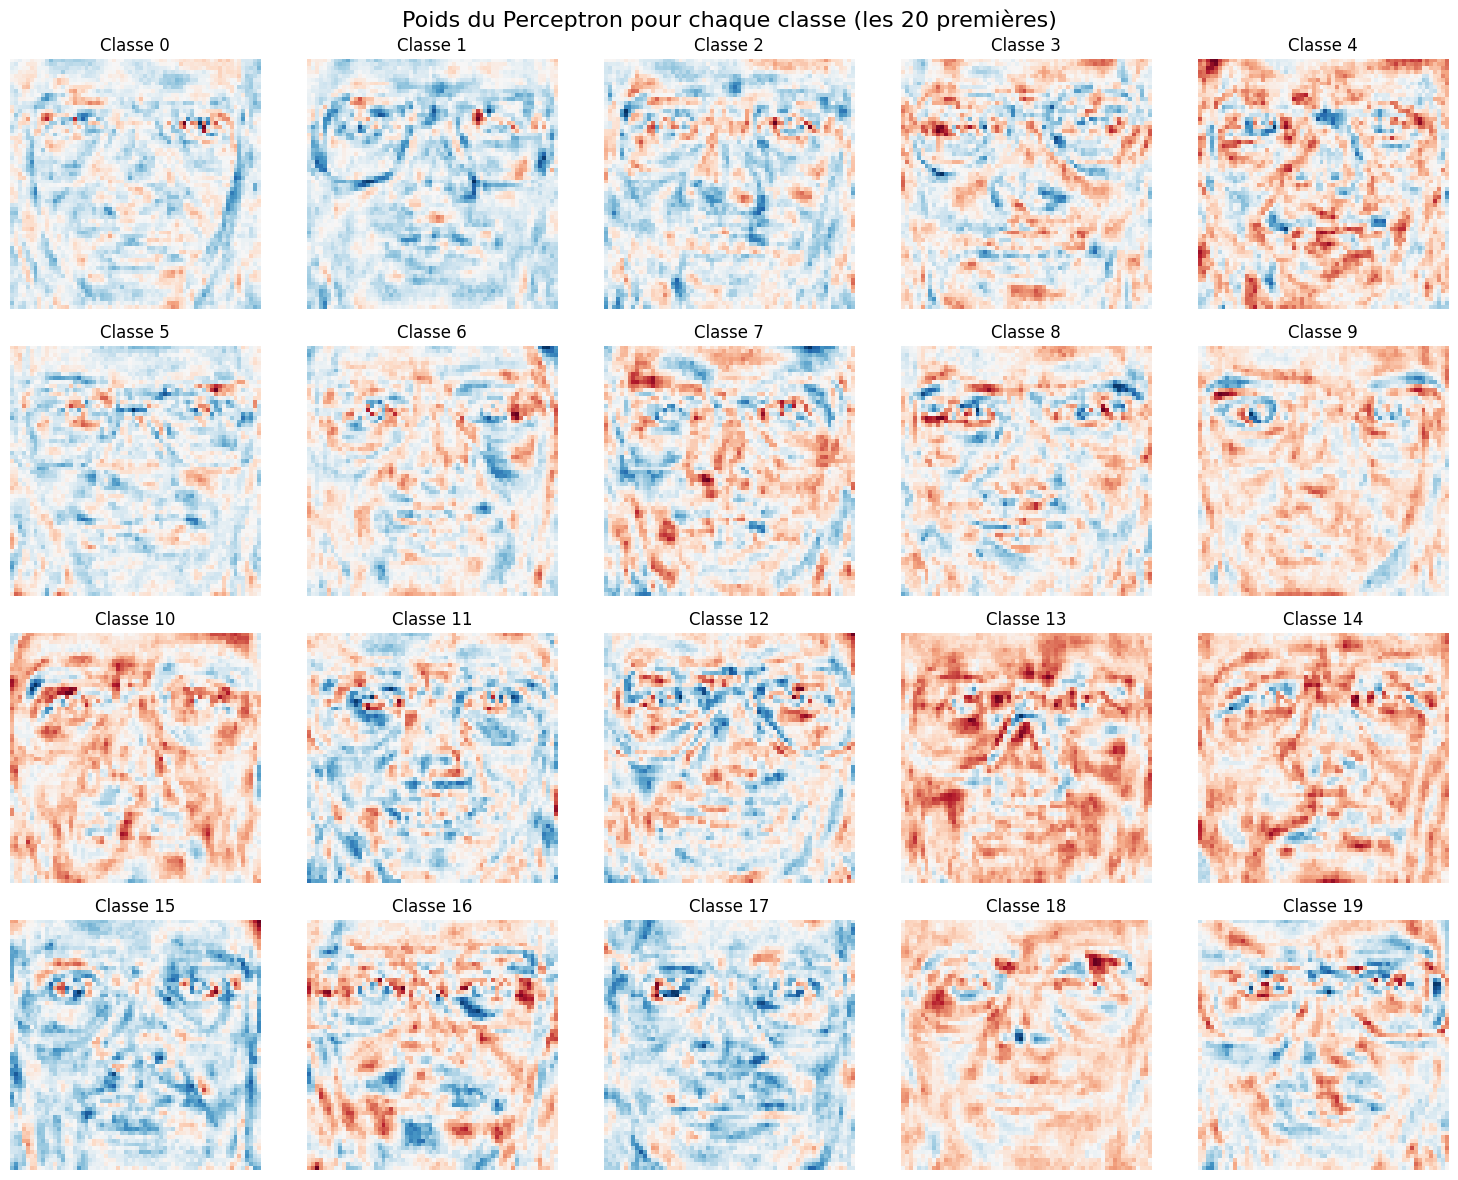

In [10]:
# Visualisation des poids du réseau
print("\n" + "="*60)
print("VISUALISATION DES POIDS DU RÉSEAU")
print("="*60)

weights_images = perceptron.get_weights_images()

# poids pour les 20 premières classes
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
fig.suptitle('Poids du Perceptron pour chaque classe (les 20 premières)', fontsize=16)

for i in range(min(20, len(perceptron.classes))):
    ax = axes[i//5, i%5]
    
    # Normalisation des poids
    weights_normalized = weights_images[i]
    weights_normalized = (weights_normalized - weights_normalized.min()) / (weights_normalized.max() - weights_normalized.min())
    
    ax.imshow(weights_normalized, cmap='RdBu_r')
    ax.set_title(f'Classe {perceptron.classes[i]}')
    ax.axis('off')

plt.tight_layout()
plt.show()


ANALYSE DES PRÉDICTIONS
 Nombre de prédictions correctes : 113
 Nombre de prédictions incorrectes : 7


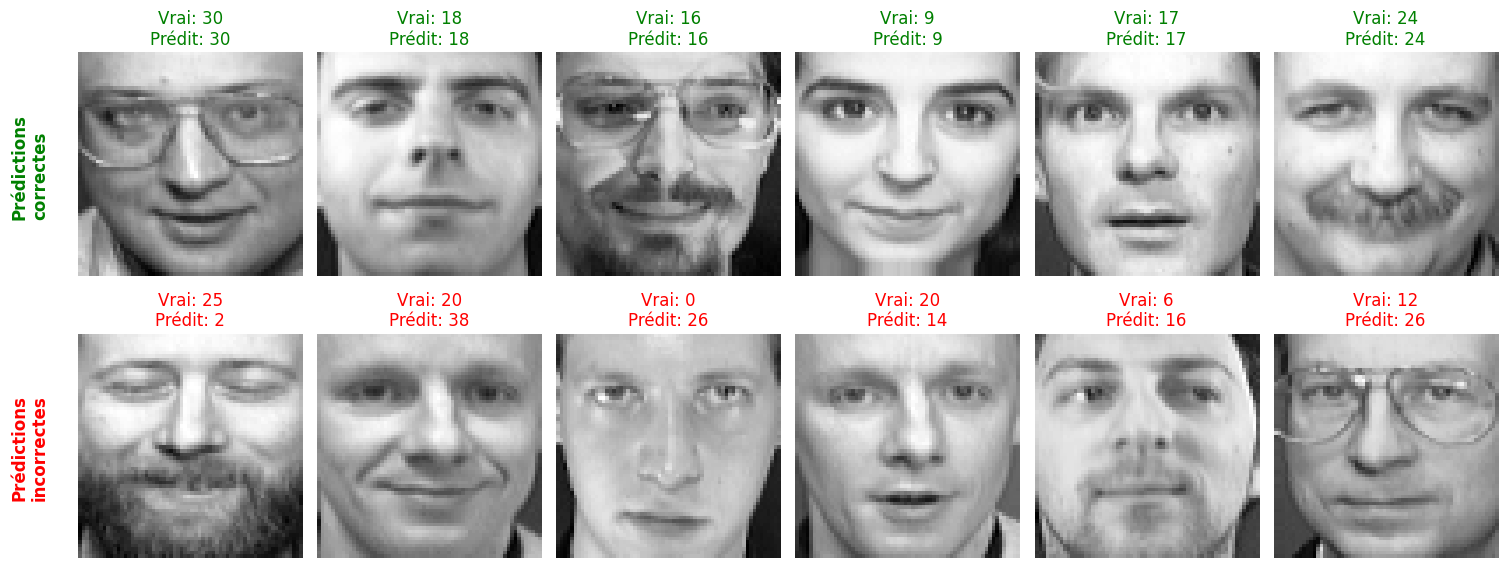

In [11]:
# prédictions correctes et incorrectes
print("\n" + "="*60)
print("ANALYSE DES PRÉDICTIONS")
print("="*60)

correct_predictions = y_test == y_test_pred
incorrect_predictions = ~correct_predictions

print(f" Nombre de prédictions correctes : {np.sum(correct_predictions)}")
print(f" Nombre de prédictions incorrectes : {np.sum(incorrect_predictions)}")

fig, axes = plt.subplots(2, 6, figsize=(15, 6))

# corrects
correct_indices = np.where(correct_predictions)[0][:6]
for i, idx in enumerate(correct_indices):
    ax = axes[0, i]
    img = X_test[idx].reshape(64, 64)
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Vrai: {y_test[idx]}\nPrédit: {y_test_pred[idx]}', color='green')
    ax.axis('off')

# incorrects
incorrect_indices = np.where(incorrect_predictions)[0][:6]
for i, idx in enumerate(incorrect_indices):
    ax = axes[1, i]
    img = X_test[idx].reshape(64, 64)
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Vrai: {y_test[idx]}\nPrédit: {y_test_pred[idx]}', color='red')
    ax.axis('off')

axes[0, 0].text(-20, 32, 'Prédictions\ncorrectes', rotation=90, 
                verticalalignment='center', fontsize=12, fontweight='bold', color='green')
axes[1, 0].text(-20, 32, 'Prédictions\nincorrectes', rotation=90, 
                verticalalignment='center', fontsize=12, fontweight='bold', color='red')

plt.tight_layout()
plt.show()

In [12]:
print("\n" + "="*60)
print("RÉSUMÉ ET ANALYSE")
print("="*60)

print(f"""
RÉSULTATS DU PERCEPTRON SIMPLE :

Performances :
   • Précision d'entraînement : {train_accuracy:.2%}
   • Précision de test : {test_accuracy:.2%}
   • Différence (surapprentissage) : {abs(train_accuracy - test_accuracy):.2%}

Configuration :
   • Taux d'apprentissage : {perceptron.learning_rate}
   • Nombre d'époques : {perceptron.max_epochs}
   • Nombre de paramètres : {perceptron.weights.size + perceptron.bias.size}

Observations :
   • Le perceptron simple arrive à capturer certaines caractéristiques des visages
   • Les poids visualisés montrent des motifs qui ressemblent à des "proto-visages"
   • Performance modeste due à la simplicité du modèle linéaire
   • Certaines classes sont mieux classifiées que d'autres
""")

# Statistiques par classe
class_accuracies = []
for cls in perceptron.classes:
    mask = y_test == cls
    if np.sum(mask) > 0:
        cls_accuracy = np.mean(y_test_pred[mask] == cls)
        class_accuracies.append(cls_accuracy)
    else:
        class_accuracies.append(0)

best_class = perceptron.classes[np.argmax(class_accuracies)]
worst_class = perceptron.classes[np.argmin(class_accuracies)]

print(f"Meilleure classe : {best_class} ({max(class_accuracies):.2%} de précision)")
print(f"Pire classe : {worst_class} ({min(class_accuracies):.2%} de précision)")



RÉSUMÉ ET ANALYSE

RÉSULTATS DU PERCEPTRON SIMPLE :

Performances :
   • Précision d'entraînement : 100.00%
   • Précision de test : 94.17%
   • Différence (surapprentissage) : 5.83%

Configuration :
   • Taux d'apprentissage : 0.1
   • Nombre d'époques : 500
   • Nombre de paramètres : 163880

Observations :
   • Le perceptron simple arrive à capturer certaines caractéristiques des visages
   • Les poids visualisés montrent des motifs qui ressemblent à des "proto-visages"
   • Performance modeste due à la simplicité du modèle linéaire
   • Certaines classes sont mieux classifiées que d'autres

Meilleure classe : 1 (100.00% de précision)
Pire classe : 20 (33.33% de précision)


Étape 2. PCA + Perceptron

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100

In [14]:
print("Chargement des données Olivetti Faces...")
faces = fetch_olivetti_faces(shuffle=True, random_state=42)
X, y = faces.data, faces.target

print(f" Forme des données originales : {X.shape}")
print(f" Dimension d'une image : {int(np.sqrt(X.shape[1]))}x{int(np.sqrt(X.shape[1]))} = {X.shape[1]} pixels")
print(f" Nombre de classes : {len(np.unique(y))}")


Chargement des données Olivetti Faces...
 Forme des données originales : (400, 4096)
 Dimension d'une image : 64x64 = 4096 pixels
 Nombre de classes : 40


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
# Normalisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f" Données préparées - Train: {X_train.shape[0]}, Test: {X_test.shape[0]}")

 Données préparées - Train: 280, Test: 120


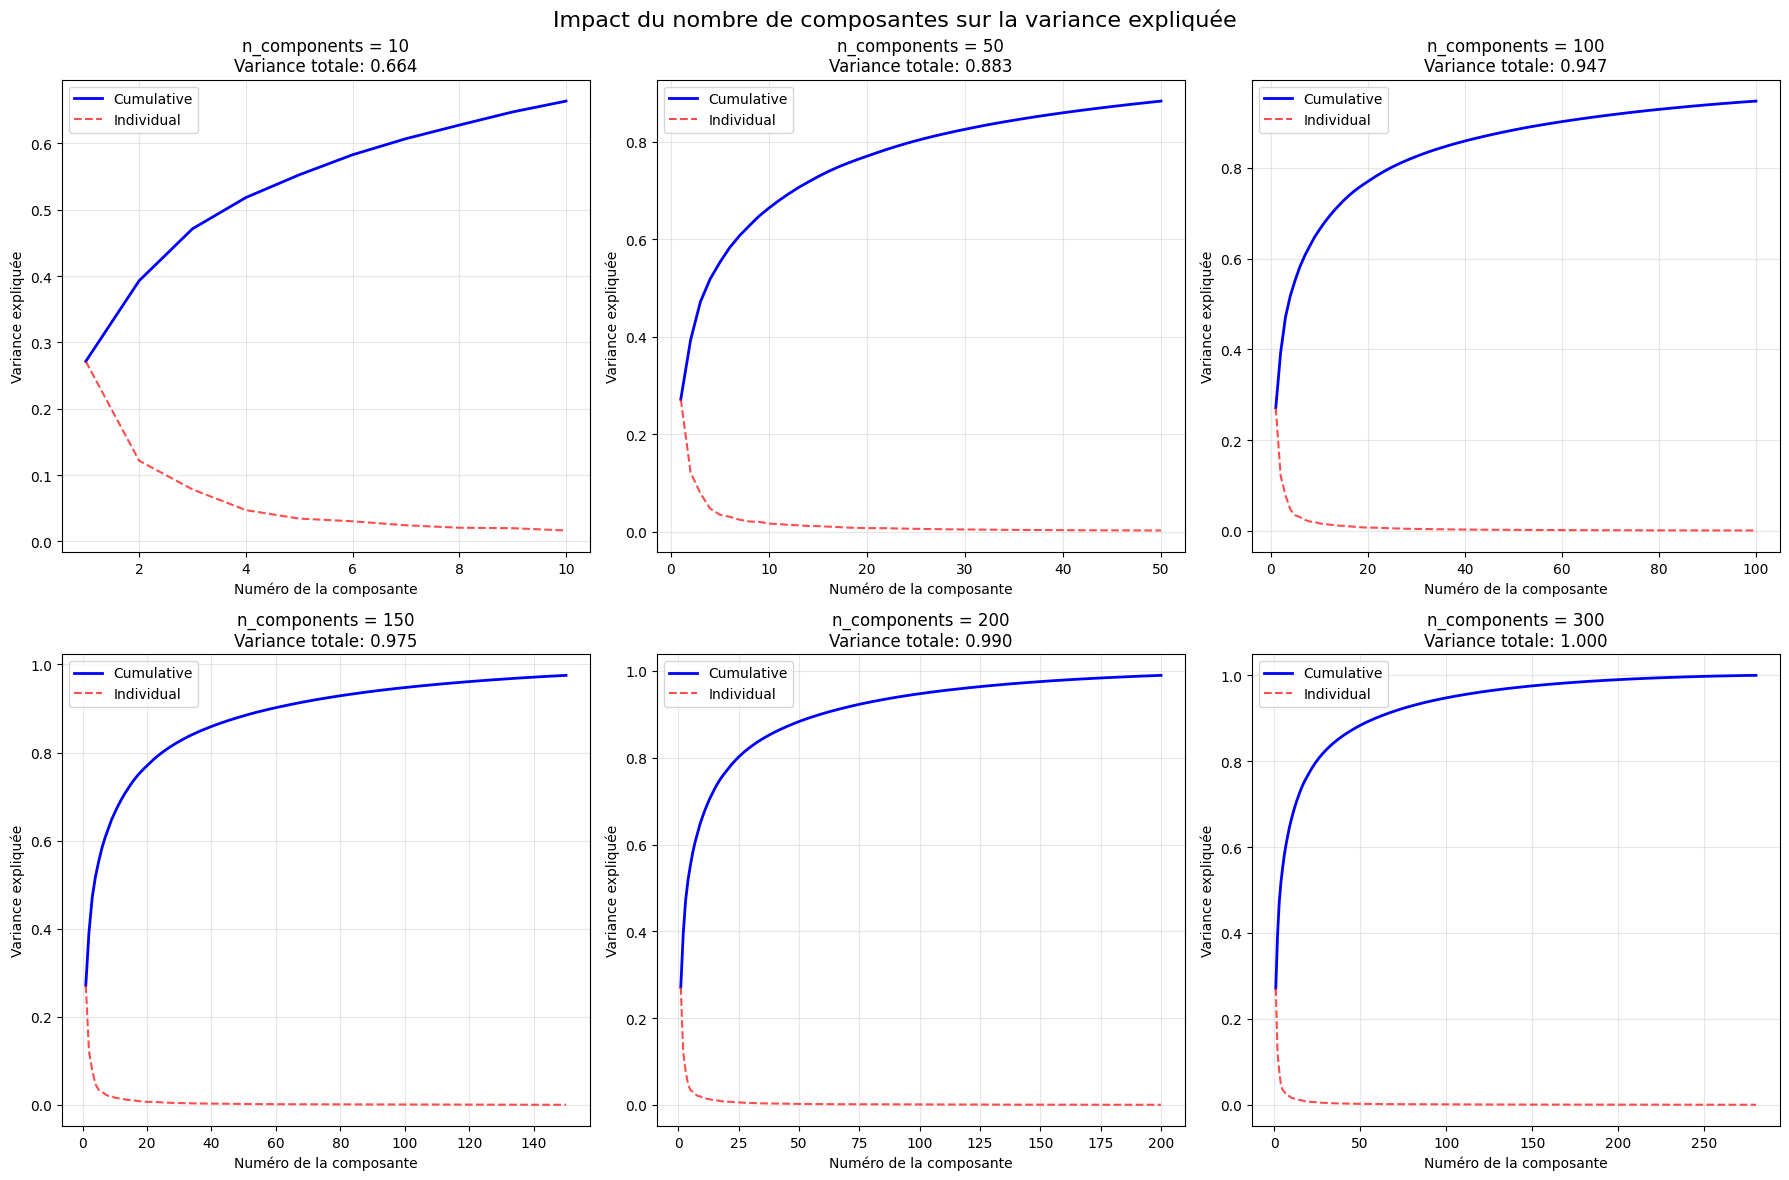

In [16]:
n_components_list = [10, 50, 100, 150, 200, 300]
explained_variances = {}

#  max possible components
n_comp_max = min(X_train_scaled.shape[0], X_train_scaled.shape[1])

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Impact du nombre de composantes sur la variance expliquée', fontsize=16)

for idx, n_comp in enumerate(n_components_list):
    ax = axes[idx//3, idx%3]
    
    # ajuster : n_components if it exceeds the maximum possible
    n_comp_adjusted = min(n_comp, n_comp_max)
    
    # Calcul PCA
    pca_temp = PCA(n_components=n_comp_adjusted, whiten=True, random_state=42)
    pca_temp.fit(X_train_scaled)
    
    explained_variances[n_comp] = {
        'cumulative': pca_temp.explained_variance_ratio_.cumsum(),
        'individual': pca_temp.explained_variance_ratio_,
        'total_variance': pca_temp.explained_variance_ratio_.sum()
    }
    
    ax.plot(range(1, n_comp_adjusted+1), pca_temp.explained_variance_ratio_.cumsum(), 
            'b-', linewidth=2, label=f'Cumulative')
    ax.plot(range(1, n_comp_adjusted+1), pca_temp.explained_variance_ratio_, 
            'r--', alpha=0.7, label=f'Individual')
    ax.set_title(f'n_components = {n_comp}\nVariance totale: {pca_temp.explained_variance_ratio_.sum():.3f}')
    ax.set_xlabel('Numéro de la composante')
    ax.set_ylabel('Variance expliquée')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

In [17]:
print("\n RÉCAPITULATIF DE LA VARIANCE EXPLIQUÉE :")
print("-" * 60)
print(f"{'Composantes':<12} {'Variance Totale':<15} {'90% à':<10} {'95% à':<10}")
print("-" * 60)

for n_comp in n_components_list:
    total_var = explained_variances[n_comp]['total_variance']
    cumul = explained_variances[n_comp]['cumulative']
    
    # Trouver où on atteint 90% et 95%
    idx_90 = np.where(cumul >= 0.90)[0]
    idx_95 = np.where(cumul >= 0.95)[0]
    
    comp_90 = idx_90[0] + 1 if len(idx_90) > 0 else "N/A"
    comp_95 = idx_95[0] + 1 if len(idx_95) > 0 else "N/A"
    
    print(f"{n_comp:<12} {total_var:<15.3f} {comp_90:<10} {comp_95:<10}")


 RÉCAPITULATIF DE LA VARIANCE EXPLIQUÉE :
------------------------------------------------------------
Composantes  Variance Totale 90% à      95% à     
------------------------------------------------------------
10           0.664           N/A        N/A       
50           0.883           N/A        N/A       
100          0.947           59         N/A       
150          0.975           59         104       
200          0.990           59         104       
300          1.000           59         104       


In [18]:
# VISUALISATION DES COMPOSANTES PRINCIPALES
n_components_optimal = 100  # Garder ~95% de la variance
pca = PCA(n_components=n_components_optimal, whiten=True, random_state=42)
pca.fit(X_train_scaled)
print(f" PCA ajustée avec {n_components_optimal} composantes")
print(f" Variance expliquée totale : {pca.explained_variance_ratio_.sum():.3f}")

 PCA ajustée avec 100 composantes
 Variance expliquée totale : 0.947


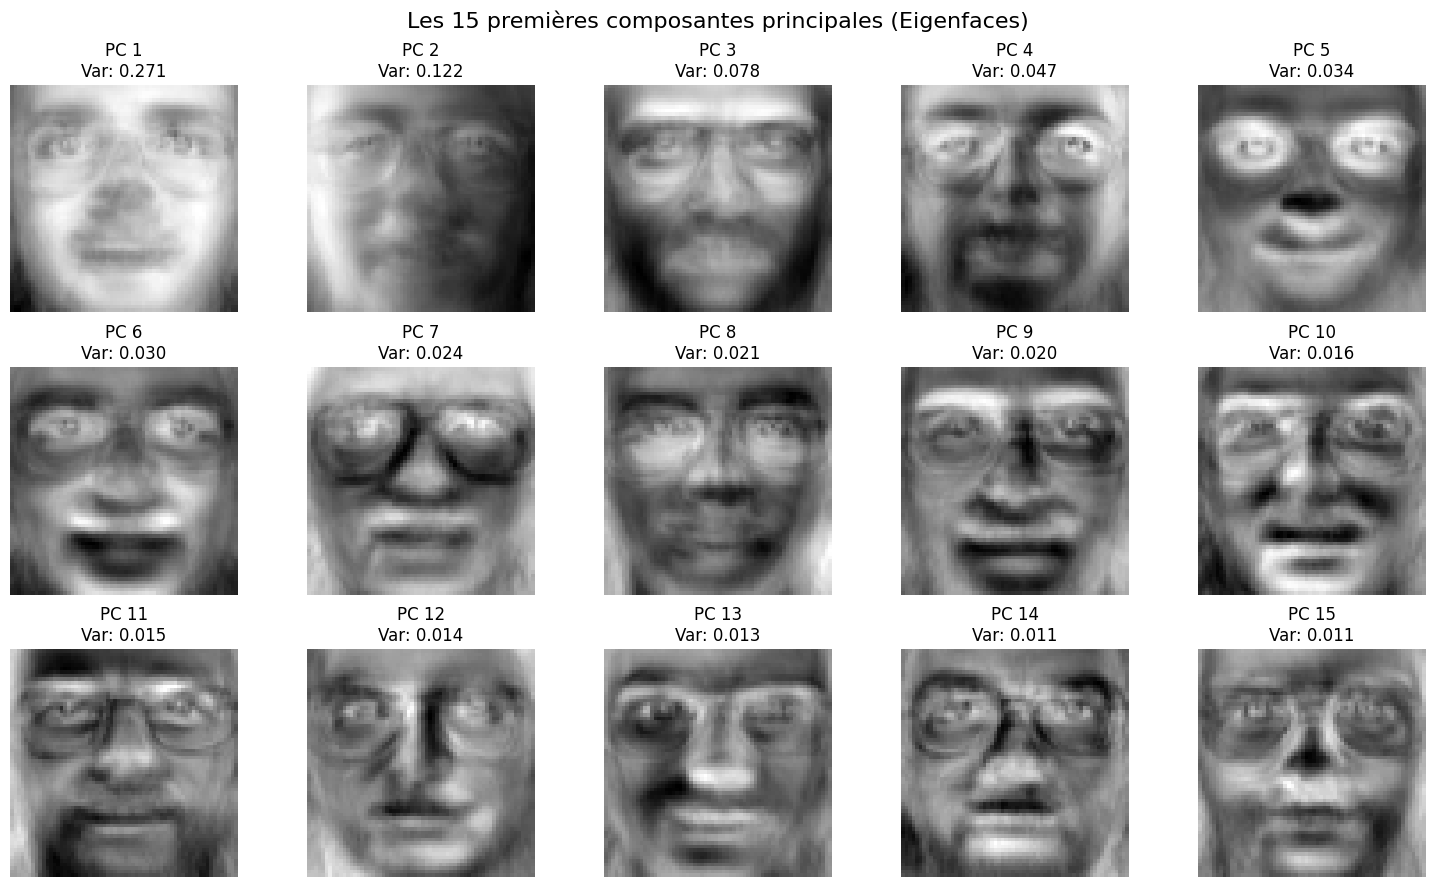

In [19]:
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
fig.suptitle('Les 15 premières composantes principales (Eigenfaces)', fontsize=16)

for i in range(15):
    ax = axes[i//5, i%5]
    # Reshape de la composante en image 64x64
    eigenface = pca.components_[i].reshape(64, 64)
    
    # Normalisation pour la visualisation
    eigenface_norm = (eigenface - eigenface.min()) / (eigenface.max() - eigenface.min())
    
    ax.imshow(eigenface_norm, cmap='gray')
    ax.set_title(f'PC {i+1}\nVar: {pca.explained_variance_ratio_[i]:.3f}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [20]:
print(f"""
RÔLE DE LA PCA DANS CE CONTEXTE :

1.  RÉDUCTION DE DIMENSIONNALITÉ :
   • Données originales : {X.shape[1]} dimensions (pixels)
   • Après PCA : {n_components_optimal} dimensions
   • Réduction : {(1 - n_components_optimal/X.shape[1])*100:.1f}%

2.  EXTRACTION DE CARACTÉRISTIQUES :
   • Les composantes principales capturent les variations les plus importantes
   • Elles ressemblent à des "eigenfaces" = visages moyens
   • Chaque visage devient une combinaison linéaire de ces eigenfaces

3.  DÉBRUITAGE :
   • Élimination des composantes de faible variance (bruit)
   • Conservation des caractéristiques essentielles
   • Amélioration potentielle de la généralisation

4.  EFFICACITÉ COMPUTATIONNELLE :
   • Moins de paramètres à apprendre pour le perceptron
   • Calculs plus rapides
   • Mémoire réduite

 CHOIX DU NOMBRE DE COMPOSANTES ({n_components_optimal}) :
   • Compromis entre information conservée et réduction
   • {pca.explained_variance_ratio_.sum():.1%} de la variance totale conservée
   • Suffisant pour capturer les caractéristiques faciales importantes
   • Réduction significative de la complexité
""")


RÔLE DE LA PCA DANS CE CONTEXTE :

1.  RÉDUCTION DE DIMENSIONNALITÉ :
   • Données originales : 4096 dimensions (pixels)
   • Après PCA : 100 dimensions
   • Réduction : 97.6%

2.  EXTRACTION DE CARACTÉRISTIQUES :
   • Les composantes principales capturent les variations les plus importantes
   • Elles ressemblent à des "eigenfaces" = visages moyens
   • Chaque visage devient une combinaison linéaire de ces eigenfaces

3.  DÉBRUITAGE :
   • Élimination des composantes de faible variance (bruit)
   • Conservation des caractéristiques essentielles
   • Amélioration potentielle de la généralisation

4.  EFFICACITÉ COMPUTATIONNELLE :
   • Moins de paramètres à apprendre pour le perceptron
   • Calculs plus rapides
   • Mémoire réduite

 CHOIX DU NOMBRE DE COMPOSANTES (100) :
   • Compromis entre information conservée et réduction
   • 94.7% de la variance totale conservée
   • Suffisant pour capturer les caractéristiques faciales importantes
   • Réduction significative de la complexité



In [21]:
class SimplePerceptron:
    """
    Implémentation d'un perceptron simple pour classification multi-classe
    """
    
    def __init__(self, learning_rate=0.01, max_epochs=1000, random_state=42):
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.random_state = random_state
        self.weights = None
        self.bias = None
        self.classes = None
        self.training_history = []
        
    def _sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        np.random.seed(self.random_state)
        
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        n_classes = len(self.classes)
        
        self.weights = np.random.normal(0, 0.01, (n_features, n_classes))
        self.bias = np.zeros(n_classes)
        
        y_one_hot = np.zeros((n_samples, n_classes))
        for i, cls in enumerate(self.classes):
            y_one_hot[y == cls, i] = 1
        
        print(f" Entraînement perceptron - Features: {n_features}, Classes: {n_classes}")
        
        for epoch in range(self.max_epochs):
            z = np.dot(X, self.weights) + self.bias
            predictions = self._sigmoid(z)
            error = y_one_hot - predictions
            cost = np.mean(np.sum(error**2, axis=1))
            
            gradient_w = -np.dot(X.T, error) / n_samples
            gradient_b = -np.mean(error, axis=0)
            
            self.weights -= self.learning_rate * gradient_w
            self.bias -= self.learning_rate * gradient_b
            
            self.training_history.append(cost)
            
            if (epoch + 1) % 100 == 0:
                accuracy = self.score(X, y)
                print(f"   Époque {epoch+1:4d} - Coût: {cost:.6f} - Précision: {accuracy:.4f}")
        
    def predict(self, X):
        z = np.dot(X, self.weights) + self.bias
        predictions = self._sigmoid(z)
        predicted_classes = np.argmax(predictions, axis=1)
        return self.classes[predicted_classes]
    
    def score(self, X, y):
        predictions = self.predict(X)
        return accuracy_score(y, predictions)

In [22]:
# PERCEPTRON SANS PCA vs AVEC PCA
# on commence sans PCA
perceptron_no_pca = SimplePerceptron(
    learning_rate=0.1,
    max_epochs=300,
    random_state=42
)

perceptron_no_pca.fit(X_train_scaled, y_train)

# Évaluation sans PCA
y_train_pred_no_pca = perceptron_no_pca.predict(X_train_scaled)
y_test_pred_no_pca = perceptron_no_pca.predict(X_test_scaled)

train_acc_no_pca = accuracy_score(y_train, y_train_pred_no_pca)
test_acc_no_pca = accuracy_score(y_test, y_test_pred_no_pca)

print(f" Précision train (sans PCA) : {train_acc_no_pca:.4f}")
print(f" Précision test (sans PCA)  : {test_acc_no_pca:.4f}")

 Entraînement perceptron - Features: 4096, Classes: 40
   Époque  100 - Coût: 14.702448 - Précision: 0.7679
   Époque  200 - Coût: 0.209470 - Précision: 1.0000
   Époque  300 - Coût: 0.003791 - Précision: 1.0000
 Précision train (sans PCA) : 1.0000
 Précision test (sans PCA)  : 0.9417


In [23]:
#AVEC PCA
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f" Dimensions après PCA - Train: {X_train_pca.shape}, Test: {X_test_pca.shape}")

perceptron_with_pca = SimplePerceptron(
    learning_rate=0.1,
    max_epochs=300,
    random_state=42
)

perceptron_with_pca.fit(X_train_pca, y_train)

# Évaluation avec PCA
y_train_pred_pca = perceptron_with_pca.predict(X_train_pca)
y_test_pred_pca = perceptron_with_pca.predict(X_test_pca)

train_acc_pca = accuracy_score(y_train, y_train_pred_pca)
test_acc_pca = accuracy_score(y_test, y_test_pred_pca)

print(f" Précision train (avec PCA) : {train_acc_pca:.4f}")
print(f" Précision test (avec PCA)  : {test_acc_pca:.4f}")

 Dimensions après PCA - Train: (280, 100), Test: (120, 100)
 Entraînement perceptron - Features: 100, Classes: 40
   Époque  100 - Coût: 0.532260 - Précision: 1.0000
   Époque  200 - Coût: 0.174132 - Précision: 1.0000
   Époque  300 - Coût: 0.089824 - Précision: 1.0000
 Précision train (avec PCA) : 1.0000
 Précision test (avec PCA)  : 0.9583


In [24]:
# Tableau comparatif
comparison_data = {
    'Méthode': ['Sans PCA', 'Avec PCA'],
    'Dimensions': [X_train_scaled.shape[1], X_train_pca.shape[1]],
    'Précision Train': [train_acc_no_pca, train_acc_pca],
    'Précision Test': [test_acc_no_pca, test_acc_pca],
    'Paramètres': [
        perceptron_no_pca.weights.size + perceptron_no_pca.bias.size,
        perceptron_with_pca.weights.size + perceptron_with_pca.bias.size
    ]
}

df_comparison = pd.DataFrame(comparison_data)
print("\n TABLEAU COMPARATIF :")
print(df_comparison.to_string(index=False))


 TABLEAU COMPARATIF :
 Méthode  Dimensions  Précision Train  Précision Test  Paramètres
Sans PCA        4096              1.0        0.941667      163880
Avec PCA         100              1.0        0.958333        4040


In [25]:
# Calcul des améliorations
improvement_test = ((test_acc_pca - test_acc_no_pca) / test_acc_no_pca) * 100
param_reduction = ((comparison_data['Paramètres'][0] - comparison_data['Paramètres'][1]) / comparison_data['Paramètres'][0]) * 100

print(f"\n AMÉLIORATIONS :")
print(f"    Précision test : {improvement_test:+.2f}%")
print(f"    Réduction paramètres : {param_reduction:.1f}%")


 AMÉLIORATIONS :
    Précision test : +1.77%
    Réduction paramètres : 97.5%


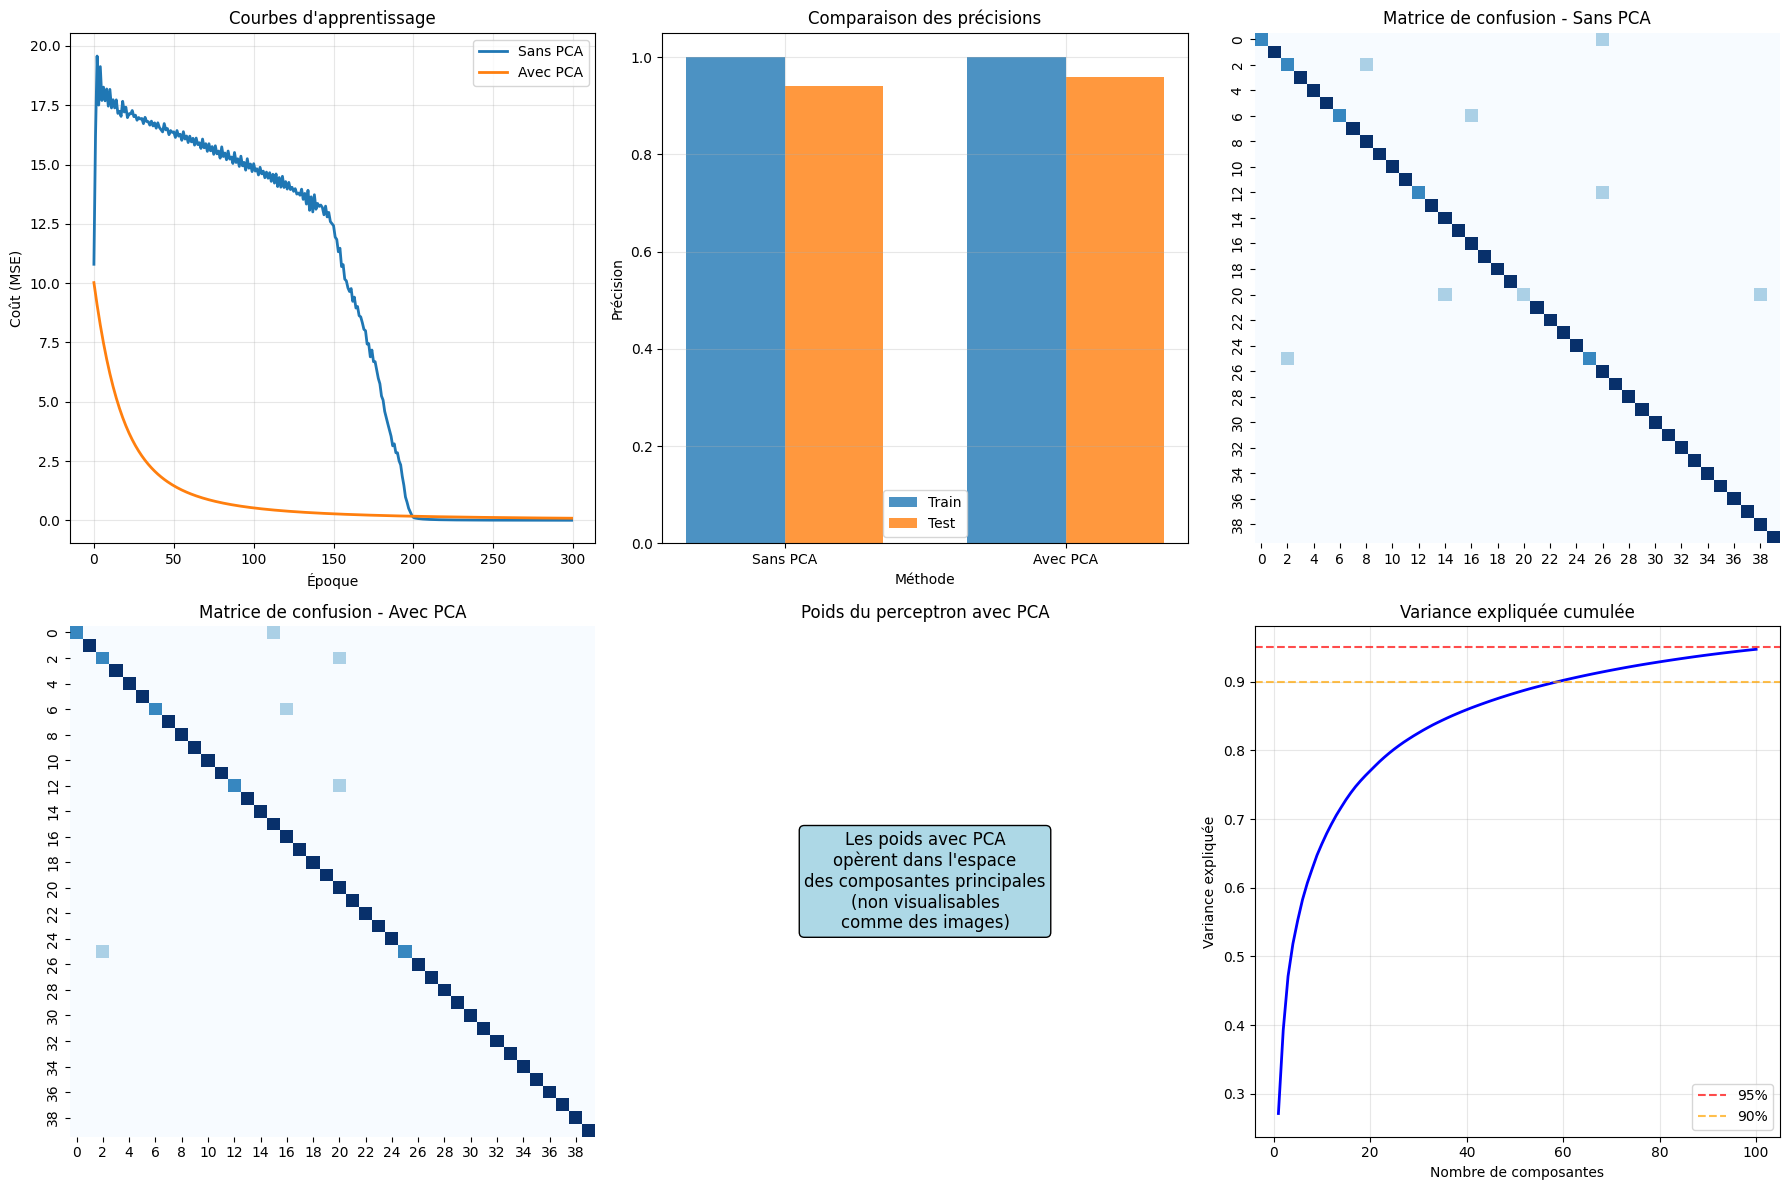

In [26]:
# comparaison
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Courbes d'apprentissage
axes[0, 0].plot(perceptron_no_pca.training_history, label='Sans PCA', linewidth=2)
axes[0, 0].plot(perceptron_with_pca.training_history, label='Avec PCA', linewidth=2)
axes[0, 0].set_title('Courbes d\'apprentissage')
axes[0, 0].set_xlabel('Époque')
axes[0, 0].set_ylabel('Coût (MSE)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Graphique en barres des précisions
methods = ['Sans PCA', 'Avec PCA']
train_accs = [train_acc_no_pca, train_acc_pca]
test_accs = [test_acc_no_pca, test_acc_pca]

x = np.arange(len(methods))
width = 0.35

axes[0, 1].bar(x - width/2, train_accs, width, label='Train', alpha=0.8)
axes[0, 1].bar(x + width/2, test_accs, width, label='Test', alpha=0.8)
axes[0, 1].set_xlabel('Méthode')
axes[0, 1].set_ylabel('Précision')
axes[0, 1].set_title('Comparaison des précisions')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(methods)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Matrice de confusion - Sans PCA
cm_no_pca = confusion_matrix(y_test, y_test_pred_no_pca)
sns.heatmap(cm_no_pca, annot=False, cmap='Blues', ax=axes[0, 2], cbar=False)
axes[0, 2].set_title('Matrice de confusion - Sans PCA')

# Matrice de confusion - Avec PCA
cm_pca = confusion_matrix(y_test, y_test_pred_pca)
sns.heatmap(cm_pca, annot=False, cmap='Blues', ax=axes[1, 0], cbar=False)
axes[1, 0].set_title('Matrice de confusion - Avec PCA')

# Visualisation des poids - dimension réduite (PCA)
# Les poids avec PCA ne peuvent pas être directement visualisés comme des images
# car ils opèrent dans l'espace PCA, pas dans l'espace pixel
axes[1, 1].text(0.5, 0.5, 'Les poids avec PCA\nopèrent dans l\'espace\ndes composantes principales\n(non visualisables\ncomme des images)', 
                ha='center', va='center', fontsize=12, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
axes[1, 1].set_xlim(0, 1)
axes[1, 1].set_ylim(0, 1)
axes[1, 1].set_title('Poids du perceptron avec PCA')
axes[1, 1].axis('off')

# Graphique de la variance expliquée
axes[1, 2].plot(range(1, len(pca.explained_variance_ratio_)+1), 
                pca.explained_variance_ratio_.cumsum(), 'b-', linewidth=2)
axes[1, 2].axhline(y=0.95, color='r', linestyle='--', alpha=0.7, label='95%')
axes[1, 2].axhline(y=0.90, color='orange', linestyle='--', alpha=0.7, label='90%')
axes[1, 2].set_title('Variance expliquée cumulée')
axes[1, 2].set_xlabel('Nombre de composantes')
axes[1, 2].set_ylabel('Variance expliquée')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


 CARACTÉRISTIQUES DES POIDS AVEC PCA :

DIMENSIONS :
   • Sans PCA : (4096, 40) (163,840 paramètres)
   • Avec PCA : (100, 40) (4,000 paramètres)
   • Réduction : 97.5%

SIGNIFICATION :
   • Les poids opèrent maintenant dans l'espace des composantes principales
   • Chaque poids correspond à l'importance d'une "eigenface"
   • Plus compact et potentiellement plus robuste au bruit

DISTRIBUTION DES POIDS :

   Sans PCA - Moyenne: -0.000170, Std: 0.057144
   Avec PCA - Moyenne: -0.000072, Std: 0.099523


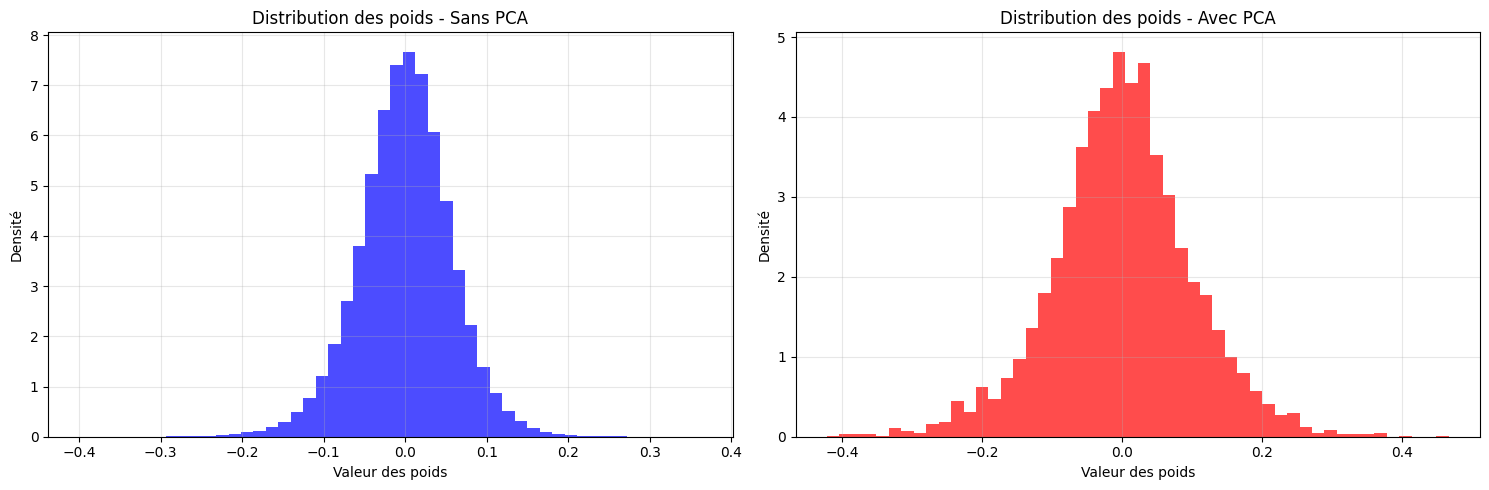

In [27]:
# 8. ANALYSE DÉTAILLÉE DES NOUVEAUX POIDS
print(f"""
 CARACTÉRISTIQUES DES POIDS AVEC PCA :

DIMENSIONS :
   • Sans PCA : {perceptron_no_pca.weights.shape} ({perceptron_no_pca.weights.size:,} paramètres)
   • Avec PCA : {perceptron_with_pca.weights.shape} ({perceptron_with_pca.weights.size:,} paramètres)
   • Réduction : {param_reduction:.1f}%

SIGNIFICATION :
   • Les poids opèrent maintenant dans l'espace des composantes principales
   • Chaque poids correspond à l'importance d'une "eigenface"
   • Plus compact et potentiellement plus robuste au bruit

DISTRIBUTION DES POIDS :
""")

# Analyse statistique des poids
weights_no_pca_flat = perceptron_no_pca.weights.flatten()
weights_pca_flat = perceptron_with_pca.weights.flatten()

print(f"   Sans PCA - Moyenne: {np.mean(weights_no_pca_flat):.6f}, Std: {np.std(weights_no_pca_flat):.6f}")
print(f"   Avec PCA - Moyenne: {np.mean(weights_pca_flat):.6f}, Std: {np.std(weights_pca_flat):.6f}")

# Histogrammes des poids
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(weights_no_pca_flat, bins=50, alpha=0.7, color='blue', density=True)
axes[0].set_title('Distribution des poids - Sans PCA')
axes[0].set_xlabel('Valeur des poids')
axes[0].set_ylabel('Densité')
axes[0].grid(True, alpha=0.3)

axes[1].hist(weights_pca_flat, bins=50, alpha=0.7, color='red', density=True)
axes[1].set_title('Distribution des poids - Avec PCA')
axes[1].set_xlabel('Valeur des poids')
axes[1].set_ylabel('Densité')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [28]:
print("\n" + "="*80)
print("CONCLUSIONS")
print("="*80)

print(f"""
 RÉSULTATS PRINCIPAUX :

1.  PERFORMANCE :
   • Précision sans PCA : {test_acc_no_pca:.2%}
   • Précision avec PCA : {test_acc_pca:.2%}
   • Amélioration : {improvement_test:+.1f}%

2.  EFFICACITÉ :
   • Réduction des paramètres : {param_reduction:.1f}%
   • Calculs plus rapides
   • Moins de risque de surapprentissage

3.  INTERPRÉTABILITÉ :
   • Les composantes PCA révèlent les structures faciales importantes
   • Les eigenfaces montrent les variations principales entre visages
   • Approche plus robuste au bruit


 UTILISER PCA QUAND :
   • Les données ont une haute dimensionnalité
   • Il y a de la redondance dans les features
   • On veut réduire le surapprentissage
   • Les ressources computationnelles sont limitées

  ATTENTION À :
   • La perte d'information (choisir assez de composantes)
   • L'interprétation des résultats (espace transformé)
   • Le coût de calcul de la PCA elle-même
""")


CONCLUSIONS

 RÉSULTATS PRINCIPAUX :

1.  PERFORMANCE :
   • Précision sans PCA : 94.17%
   • Précision avec PCA : 95.83%
   • Amélioration : +1.8%

2.  EFFICACITÉ :
   • Réduction des paramètres : 97.5%
   • Calculs plus rapides
   • Moins de risque de surapprentissage

3.  INTERPRÉTABILITÉ :
   • Les composantes PCA révèlent les structures faciales importantes
   • Les eigenfaces montrent les variations principales entre visages
   • Approche plus robuste au bruit


 UTILISER PCA QUAND :
   • Les données ont une haute dimensionnalité
   • Il y a de la redondance dans les features
   • On veut réduire le surapprentissage
   • Les ressources computationnelles sont limitées

  ATTENTION À :
   • La perte d'information (choisir assez de composantes)
   • L'interprétation des résultats (espace transformé)
   • Le coût de calcul de la PCA elle-même



Étape 3. Réseau multi-couches

In [29]:
import os, warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"   # silence TF
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.linear_model import Perceptron

In [30]:
data      = fetch_olivetti_faces()
X, y      = data.images, data.target          # X:(400,64,64)
n_samples = X.shape[0]
h, w      = X.shape[1:]

print(f" Dataset: {n_samples} images de {h}x{w} pixels, {len(np.unique(y))} personnes")
print(f" Répartition: {np.bincount(y)[0]} images par personne")

 Dataset: 400 images de 64x64 pixels, 40 personnes
 Répartition: 10 images par personne


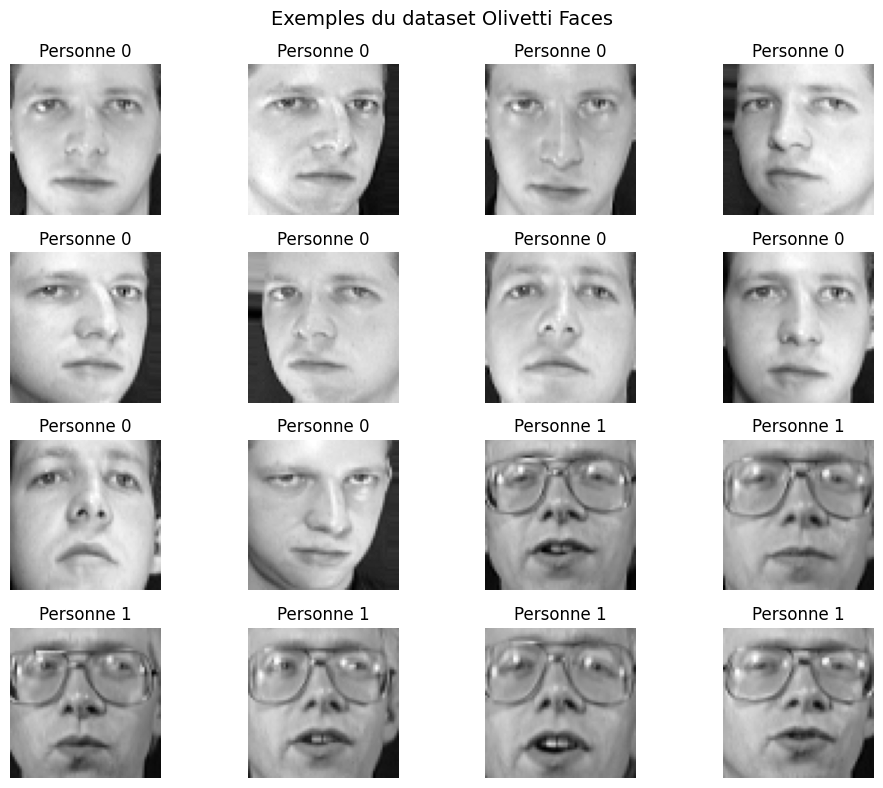

In [31]:
plt.figure(figsize=(10,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(X[i], cmap="gray")
    plt.axis("off")
    plt.title(f"Personne {y[i]}")
plt.suptitle("Exemples du dataset Olivetti Faces", fontsize=14)
plt.tight_layout()
plt.show()

In [32]:
#PROCESSING
X_flat = X.reshape(n_samples, h*w).astype("float32")
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y, test_size=0.25, stratify=y, random_state=42
)
n_classes   = 40
Y_train_oh  = to_categorical(y_train, n_classes)
Y_test_oh   = to_categorical(y_test , n_classes)

print(f"   Shapes après split:")
print(f"   X_train: {X_train.shape} | Y_train: {Y_train_oh.shape}")
print(f"   X_test:  {X_test.shape}  | Y_test:  {Y_test_oh.shape}")

   Shapes après split:
   X_train: (300, 4096) | Y_train: (300, 40)
   X_test:  (100, 4096)  | Y_test:  (100, 40)


In [33]:
print("\n Comparaison avec un Perceptron simple...")
perceptron = Perceptron(max_iter=1000, random_state=42)
perceptron.fit(X_train, y_train)
perc_pred = perceptron.predict(X_test)
perc_acc = accuracy_score(y_test, perc_pred)
print(f"   Précision Perceptron simple: {perc_acc*100:.2f}%")


 Comparaison avec un Perceptron simple...
   Précision Perceptron simple: 81.00%


In [34]:
#Modèle MLP
model = Sequential(name="Olivetti_MLP")
model.add(Dense(512, input_shape=(h*w,), activation="relu", name="hidden1"))
model.add(Dropout(0.30, name="dropout1"))
model.add(Dense(256, activation="relu", name="hidden2"))
model.add(Dropout(0.20, name="dropout2"))  # Dropout plus léger pour la 2e couche
model.add(Dense(128, activation="relu", name="hidden3"))  # Couche supplémentaire
model.add(Dense(n_classes, activation="softmax", name="output"))

print(f" Architecture du modèle:")
model.summary()
plot_model(model, to_file="mlp_faces_archi.png", show_shapes=True, show_layer_names=True)

# Compilation avec métriques supplémentaires
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy", "top_k_categorical_accuracy"]  # Top-k accuracy utile pour 40 classes
)

 Architecture du modèle:


Model: "Olivetti_MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 40)             │         5,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,267,048 (8.65 MB)

 Trainable params: 2,267,048 (8.65 MB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [35]:
# Callbacks améliorés (entraînement)
early = EarlyStopping(patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history = model.fit(
    X_train, Y_train_oh,
    epochs=100,  # Plus d'époques avec early stopping
    batch_size=16,  # Batch plus petit pour ce petit dataset
    validation_split=0.2,
    callbacks=[early, reduce_lr],
    verbose=1
)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.0509 - loss: 4.4356 - top_k_categorical_accuracy: 0.1538 - val_accuracy: 0.0167 - val_loss: 3.7560 - val_top_k_categorical_accuracy: 0.1167 - learning_rate: 0.0010
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.0054 - loss: 4.0815 - top_k_categorical_accuracy: 0.0839 - val_accuracy: 0.0333 - val_loss: 3.7838 - val_top_k_categorical_accuracy: 0.0333 - learning_rate: 0.0010
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.0436 - loss: 3.7617 - top_k_categorical_accuracy: 0.1408 - val_accuracy: 0.0167 - val_loss: 3.7998 - val_top_k_categorical_accuracy: 0.0833 - learning_rate: 0.0010
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.0324 - loss: 3.7802 - top_k_categorical_accuracy: 0.1350 - val_accuracy: 0.0000e+00 - val_loss: 3.7161 - val_top_k_categorical_accuracy: 0.0833 - learning_rate: 0.0010
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.0586 - los

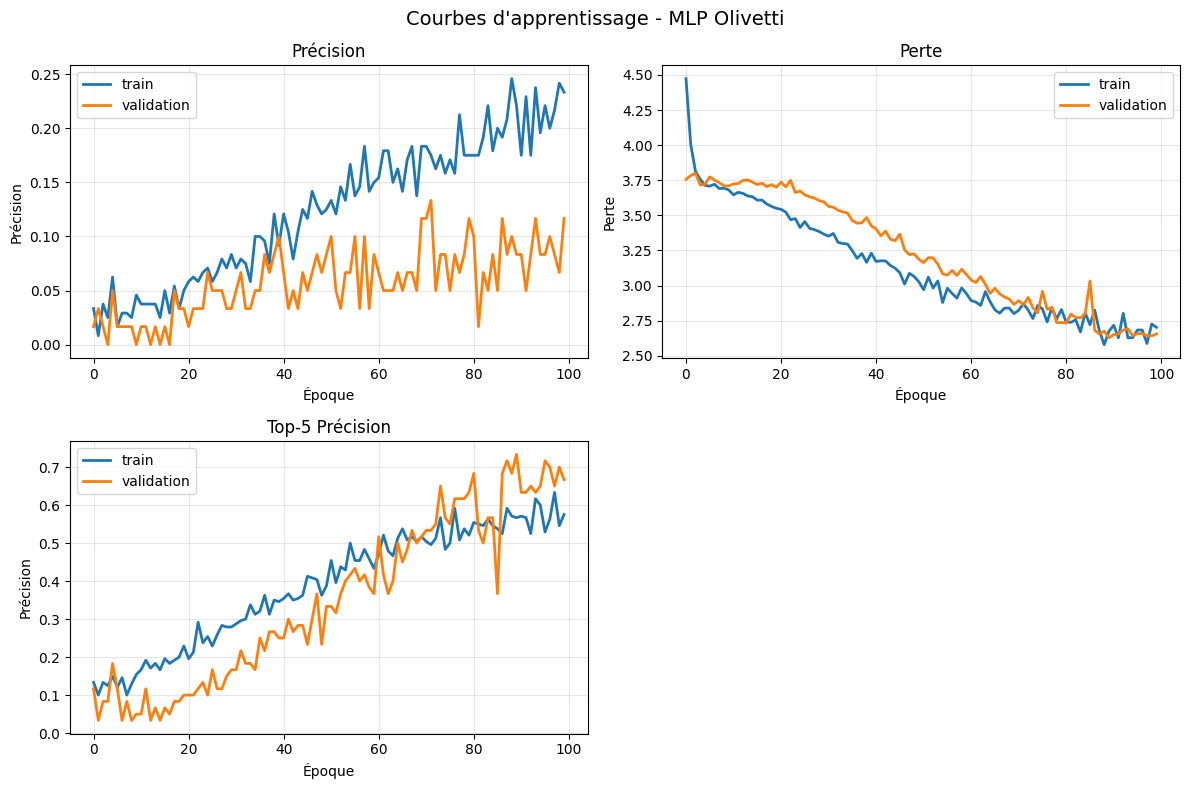

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Accuracy
axes[0,0].plot(history.history["accuracy"], label="train", linewidth=2)
axes[0,0].plot(history.history["val_accuracy"], label="validation", linewidth=2)
axes[0,0].set_title("Précision")
axes[0,0].set_xlabel("Époque")
axes[0,0].set_ylabel("Précision")
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Loss
axes[0,1].plot(history.history["loss"], label="train", linewidth=2)
axes[0,1].plot(history.history["val_loss"], label="validation", linewidth=2)
axes[0,1].set_title("Perte")
axes[0,1].set_xlabel("Époque")
axes[0,1].set_ylabel("Perte")
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Top-k accuracy
axes[1,0].plot(history.history["top_k_categorical_accuracy"], label="train", linewidth=2)
axes[1,0].plot(history.history["val_top_k_categorical_accuracy"], label="validation", linewidth=2)
axes[1,0].set_title("Top-5 Précision")
axes[1,0].set_xlabel("Époque")
axes[1,0].set_ylabel("Précision")
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Learning rate
if 'lr' in history.history:
    axes[1,1].plot(history.history["lr"], linewidth=2)
    axes[1,1].set_title("Taux d'apprentissage")
    axes[1,1].set_xlabel("Époque")
    axes[1,1].set_ylabel("Learning Rate")
    axes[1,1].set_yscale('log')
    axes[1,1].grid(True, alpha=0.3)
else:
    axes[1,1].axis('off')

plt.suptitle("Courbes d'apprentissage - MLP Olivetti", fontsize=14)
plt.tight_layout()
plt.show()

In [37]:
print("\n Évaluation du modèle:")
test_loss, test_acc, test_top5 = model.evaluate(X_test, Y_test_oh, verbose=0)
print(f"   Test accuracy     : {test_acc*100:.2f}%")
print(f"   Test top-5 accuracy: {test_top5*100:.2f}%")
print(f"   Test loss         : {test_loss:.4f}")

# Comparaison avec le perceptron
print(f"\n Comparaison:")
print(f"   Perceptron simple : {perc_acc*100:.2f}%")
print(f"   MLP multicouches  : {test_acc*100:.2f}%")
print(f"   Amélioration      : +{(test_acc-perc_acc)*100:.2f} points")

y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)

print(f"\n Classification Report:")
print(classification_report(y_test, y_pred, digits=3))


 Évaluation du modèle:
   Test accuracy     : 33.00%
   Test top-5 accuracy: 79.00%
   Test loss         : 2.3616

 Comparaison:
   Perceptron simple : 81.00%
   MLP multicouches  : 33.00%
   Amélioration      : +-48.00 points

 Classification Report:
              precision    recall  f1-score   support

           0      0.143     0.500     0.222         2
           1      0.000     0.000     0.000         3
           2      1.000     0.333     0.500         3
           3      0.000     0.000     0.000         3
           4      0.400     1.000     0.571         2
           5      1.000     0.667     0.800         3
           6      0.000     0.000     0.000         2
           7      0.000     0.000     0.000         3
           8      0.000     0.000     0.000         2
           9      0.143     0.500     0.222         2
          10      0.500     1.000     0.667         3
          11      1.000     0.333     0.500         3
          12      0.000     0.000     0.000 

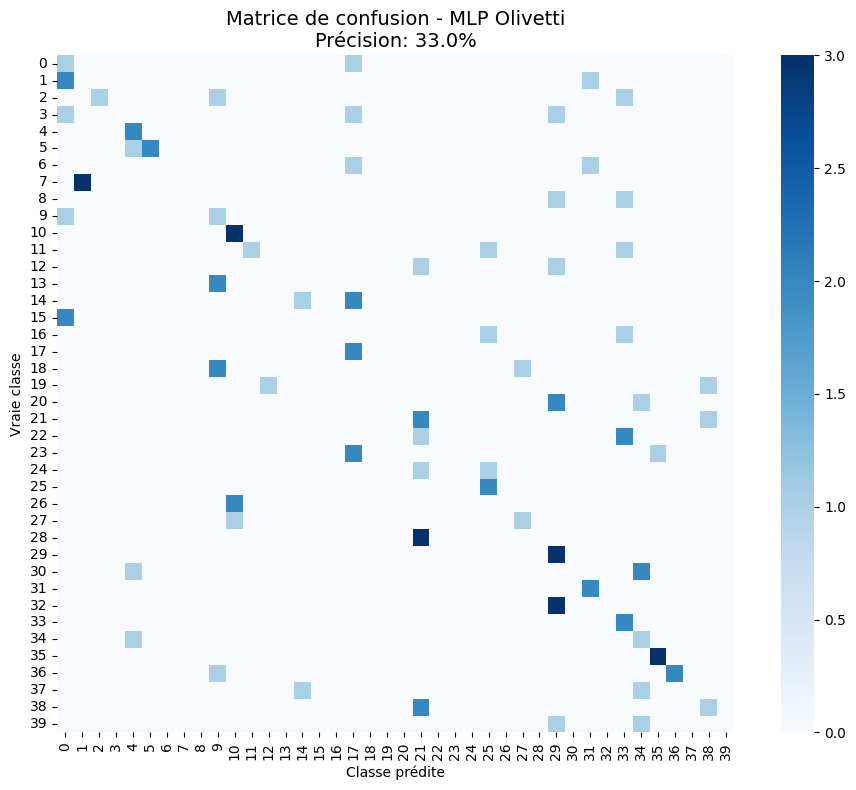

In [38]:
plt.figure(figsize=(10,8))
cfm = confusion_matrix(y_test, y_pred)
sns.heatmap(cfm, annot=False, cmap="Blues", cbar=True, square=True)
plt.title(f"Matrice de confusion - MLP Olivetti\nPrécision: {test_acc*100:.1f}%", fontsize=14)
plt.ylabel("Vraie classe")
plt.xlabel("Classe prédite")
plt.tight_layout()
plt.show()

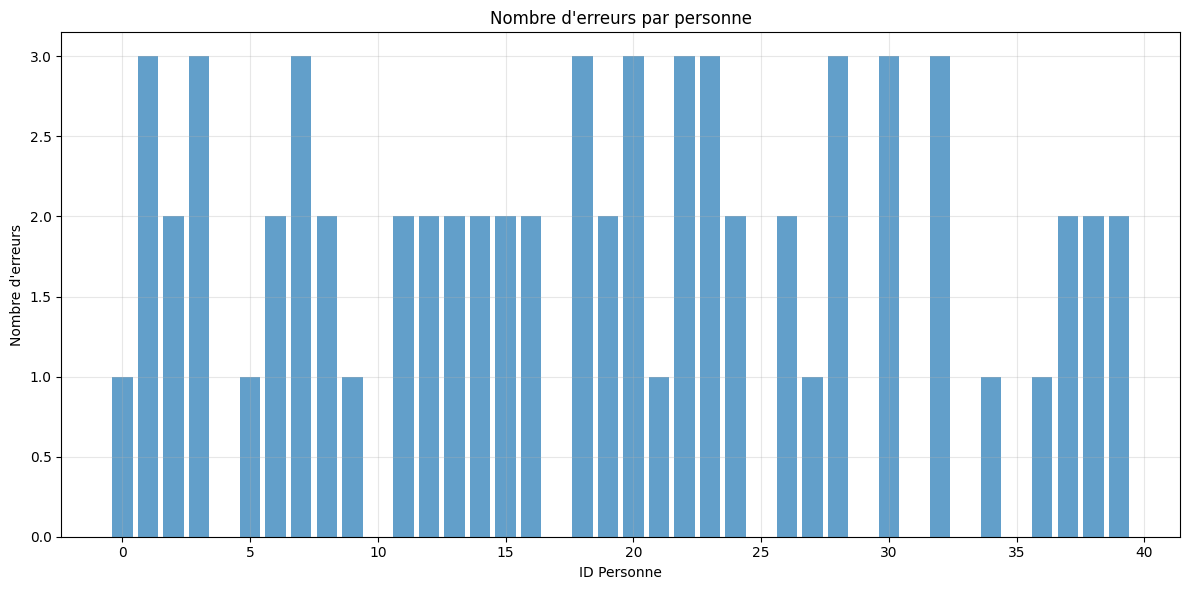

In [39]:
errors_per_person = []
for person in range(40):
    person_indices = np.where(y_test == person)[0]
    if len(person_indices) > 0:
        person_errors = np.sum(y_pred[person_indices] != y_test[person_indices])
        errors_per_person.append(person_errors)
    else:
        errors_per_person.append(0)

plt.figure(figsize=(12,6))
plt.bar(range(40), errors_per_person, alpha=0.7)
plt.title("Nombre d'erreurs par personne")
plt.xlabel("ID Personne")
plt.ylabel("Nombre d'erreurs")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

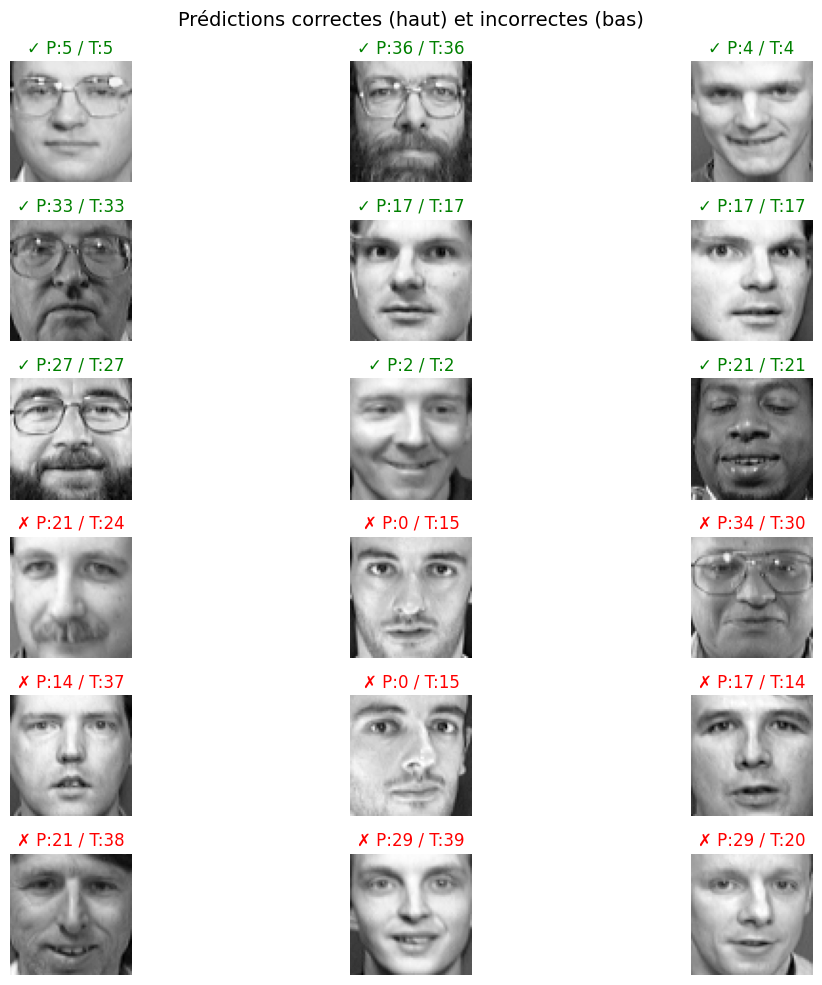

In [40]:
# VISU PRÉDICTIONS
corr_idx = np.where(y_pred == y_test)[0][:9]
incorr_idx = np.where(y_pred != y_test)[0][:9]

plt.figure(figsize=(12,10))

# Prédictions correctes
for i, idx in enumerate(corr_idx):
    plt.subplot(6,3,i+1)
    plt.imshow(X_test[idx].reshape(h,w), cmap="gray")
    plt.title(f"✓ P:{y_pred[idx]} / T:{y_test[idx]}", color='green')
    plt.axis("off")

# Prédictions incorrectes
for i, idx in enumerate(incorr_idx):
    plt.subplot(6,3,i+10)
    plt.imshow(X_test[idx].reshape(h,w), cmap="gray")
    plt.title(f"✗ P:{y_pred[idx]} / T:{y_test[idx]}", color='red')
    plt.axis("off")

plt.suptitle("Prédictions correctes (haut) et incorrectes (bas)", fontsize=14)
plt.tight_layout()
plt.show()


 Analyse des poids de la première couche...
   Shape des poids couche 1: (4096, 512)


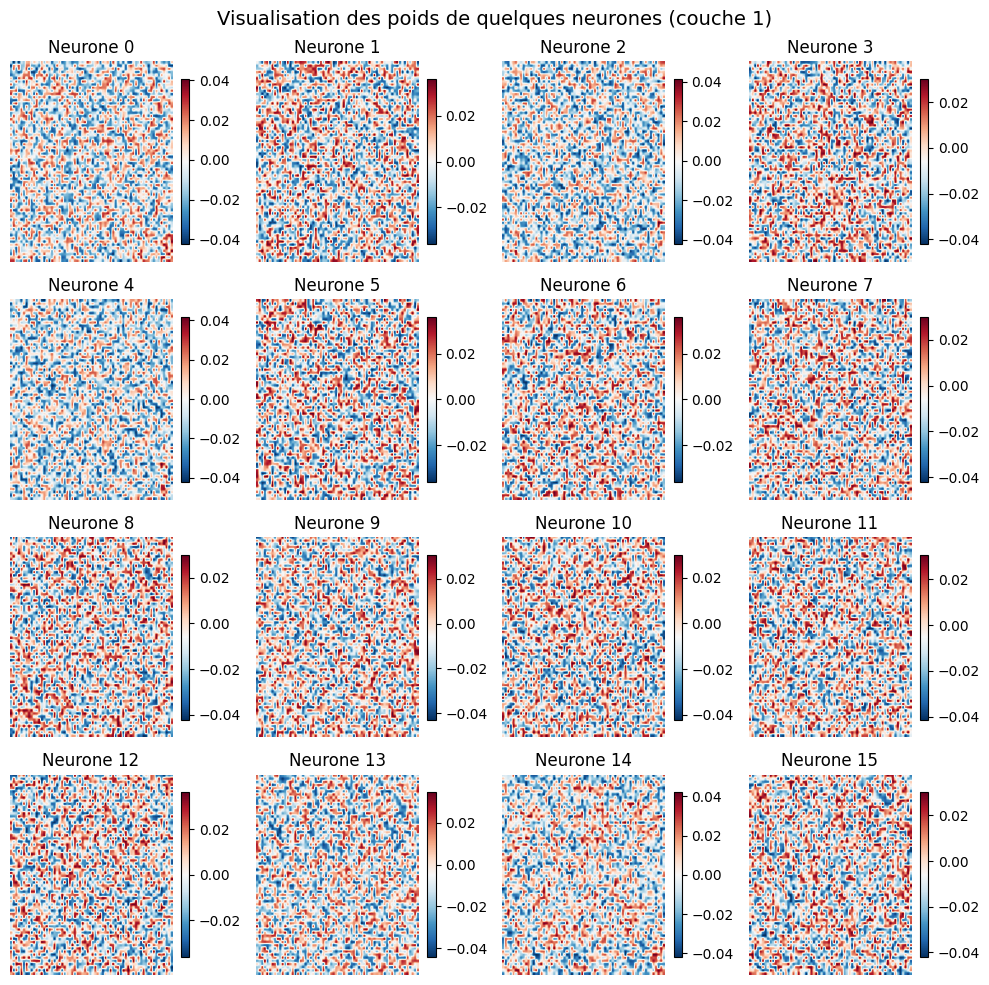

In [41]:
#analyse des poids 

print("\n Analyse des poids de la première couche...")
weights_layer1 = model.layers[0].get_weights()[0]  # Shape: (4096, 512)
print(f"   Shape des poids couche 1: {weights_layer1.shape}")

# Visualisation de quelques filtres de la première couche
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i in range(16):
    ax = axes[i//4, i%4]
    weight_reshaped = weights_layer1[:, i].reshape(h, w)
    im = ax.imshow(weight_reshaped, cmap='RdBu_r', aspect='auto')
    ax.set_title(f'Neurone {i}')
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046)

plt.suptitle("Visualisation des poids de quelques neurones (couche 1)", fontsize=14)
plt.tight_layout()
plt.show()